In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import pi

def exp_format(x, pos=None):
    names = {1: 'Delay',
            2: 'Delay PD',
            3: 'No delay'}
    return names[x]

pair_dict = [{'name':'Delay - Delay PD', 'a':0, 'b':1},
            {'name':'Delay - No delay', 'a':0, 'b':2},
            {'name':'Delay PD - No delay', 'a':1, 'b':2}]

In [3]:
conn = sqlite3.connect("data.db")
act = pd.read_sql_query("select rowid, * from actors where valid=1;", conn)

### Significance, Paired sample t-test and Cohen's D

In [220]:
from numpy import std, mean, sqrt

def welch_dof(x,y):
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof

def dependent_dof(x,y):
    return (len(x)+len(y))/2-1

def cohen_d(x,y):
    x = x.tolist()
    y = y.tolist()
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

def print_sig(a, b, equal_var=False, dependent=True):
    if len(a) == len(b):
        t_stat, p_value = stats.ttest_rel(b, a)
        dof = dependent_dof(a, b)
    else:
        dependent = False
        t_stat, p_value = stats.ttest_ind(b, a, equal_var=equal_var)
        dof = welch_dof(a,b)
    d_value = cohen_d(b, a)

    if dependent:
        if p_value < 0.001:
            print('t({:.0f})={:.2f}, p$<$.001, d={:.3f}'.format(dof, t_stat, d_value))
        else:
            print('t({:.0f})={:.2f}, p={:.3f}, d={:.3f}'.format(dof, t_stat, p_value, d_value))
    else:
        if p_value < 0.001:
            print('t({:.2f})={:.2f}, p$<$.001, d={:.3f}'.format(dof, t_stat, d_value))
        else:
            print('t({:.2f})={:.2f}, p={:.3f}, d={:.3f}'.format(dof, t_stat, p_value, d_value))

## Recorded data

In [14]:
all_act = pd.read_sql_query("select * from actors where valid=1;", conn)
all_hits = pd.read_sql_query("select * from hits where valid=1;", conn)
all_survey = pd.read_sql_query("select * from survey where valid=1;", conn)
print('A total of {} data points were collected'.format(all_act.size+all_hits.size+all_survey.size))

A total of 11865 data points were collected


## Task times

In [15]:
times = pd.read_sql_query("select start, end from actors where valid=1;", conn)
length = np.array(times['end']-times['start'])
minutes = length.mean()/60-length.mean()/60%1
seconds = (length.mean()/60)%1*60
minutes_std = length.std()/60-length.std()/60%1
seconds_std = (length.std()/60)%1*60


print('Subjects used on average {:.0f} minutes and {:.0f} seconds with a standard deviation of {:.0f}min and {:.0f}s'
     .format(minutes, seconds, minutes_std, seconds_std))

Subjects used on average 10 minutes and 56 seconds with a standard deviation of 1min and 12s


## Demographics

In [12]:
valid_n = len(pd.read_sql_query("select age, gender, education, computer, eye from actors where valid=1;", conn))
non_valid = pd.read_sql_query("select age, gender, education, computer, eye from actors where valid=0;", conn)
female = pd.read_sql_query("select age, gender, education, computer, eye from actors where gender=1 and valid=1;", conn)
male = pd.read_sql_query("select age, gender, education, computer, eye from actors where gender=0 and valid=1;", conn)
ages_df = pd.read_sql_query("select age from actors where valid=1;", conn)
ages = np.array(ages_df)
game = []
frequency = ['Daily', 'Weekly', 'Monthly', 'Yearly', 'Never']
print('Gaming:')
for i in range(5):
    query = "select * from actors where valid=1 and game={};".format(i)
    n_people = len(pd.read_sql_query(query, conn))
    print('{}: {}, {:.1f}'.format(frequency[i], n_people, n_people/valid_n*100))


print('{} total participants, {} excluded'.format(valid_n+len(non_valid),len(non_valid) ))
print('{} males {:.1f}, {} females {:.1f}'.format(len(male), len(male)/valid_n*100, len(female), len(female)/valid_n*100))
# print('{:.1f}% females'.format(len(female)/valid_n*100))
print('Average age of {:.1f} years with a SD of {:.2f}'.format(float(ages.mean(axis=0)), float(ages.std(axis=0))))
print('100% said they use computer on a daily basis ')
# print('Gaming: daily {:.0f}%, weekly {:.0f}%, monthly {:.0f}%, yearly {:.0f}% and never {:.0f}%'.format(*[i/valid_n*100 for i in game]))

Gaming:
Daily: 2, 3.5
Weekly: 15, 26.3
Monthly: 8, 14.0
Yearly: 17, 29.8
Never: 15, 26.3
58 total participants, 1 excluded
38 males 66.7, 19 females 33.3
Average age of 24.7 years with a SD of 1.45
100% said they use computer on a daily basis 


## Performance

### Absolute

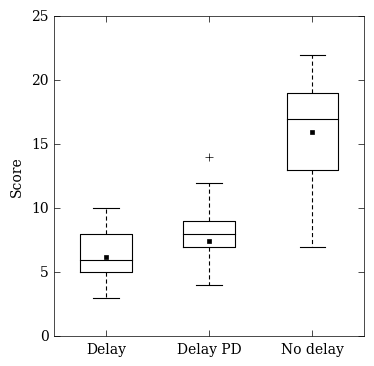

Delay - Delay PD    t(56)=4.92, p$<$.001, d=0.700
Delay - No delay    t(56)=19.88, p$<$.001, d=3.211
Delay PD - No delay t(56)=17.95, p$<$.001, d=2.717


In [222]:
filename = 'performance_abs'

hits = np.array(act[['tothitsexp0', 'tothitsexp1', 'tothitsexp2']]).astype(float)

fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(hits, whis=2, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Score')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')
for di in pair_dict:
    print('{:<20}'.format(di['name']), end='')
    print_sig(hits[...,di['a']], hits[...,di['b']])

In [185]:
means = hits.mean(axis=0)

x = np.reshape(np.reciprocal(means), (3,1))
y = np.reshape(means, (1,3))
change = np.dot(x,y)-1
change = change.T

d = {'experiment':[exp_format(i+1) for i in range(3)],
    'mean':means,
    'std':hits.std(axis=0),
    'max':hits.max(axis=0),
    'min':hits.min(axis=0),
     'median':np.median(hits, axis=0),
    'diff_delay':change[...,0],
    'diff_pd':change[...,1],
    'diff_normal':change[...,2],
    }
table = pd.DataFrame(data=d)
table

,diff_delay,diff_normal,diff_pd,experiment,max,mean,median,min,std
0,0.000000,-0.611661,-0.173302,Delay,10.0,6.192982,6.0,3.0,1.711044
1,0.209632,-0.530253,0.000000,Delay PD,14.0,7.491228,8.0,4.0,1.956750
2,1.575071,0.000000,1.128806,No delay,22.0,15.947368,17.0,7.0,3.899712


In [216]:
print('Mean differences for score compared to all experiments\n{}'.format('-'*57))
print('{:9} {:>21} {:>16} {:>16} {:>16}'.format('', 'Score', *(exp_format(i+1) for i in range(3))))
for idx, row in table.iterrows():
    print('{:9} {:>10.2f} $\pm${:>5.2f} {:>14.2f}\% {:>14.2f}\% {:>14.2f}\%'.format(exp_format(idx+1),
                                           row['mean'],
                                           row['std'],
                                           row['diff_delay']*100, 
                                           row['diff_pd']*100, 
                                           row['diff_normal']*100))

Mean differences for score compared to all experiments
---------------------------------------------------------
                          Score            Delay         Delay PD         No delay
Delay           6.24 $\pm$ 1.39          -0.00\%         -17.10\%         -60.69\%
Delay PD        7.52 $\pm$ 1.43          20.62\%           0.00\%         -52.58\%
No delay       15.87 $\pm$ 1.99         154.37\%         110.88\%           0.00\%


### Normalized

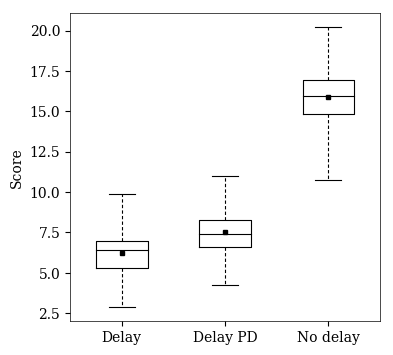

Delay - Delay PD    t(56)=4.80, p$<$.001, d=0.904
Delay - No delay    t(56)=23.15, p$<$.001, d=5.569
Delay PD - No delay t(56)=19.66, p$<$.001, d=4.772


In [229]:
filename = 'performance_norm'
plt.style.use('default')
plt.style.use('thesis.mplstyle')

hits = np.array(act[['tothitsexp0', 'tothitsexp1', 'tothitsexp2']]).astype(float)
total_mean = hits.mean()
norm = np.zeros((hits.shape[0],3))
for i, row in enumerate(hits):
    user_mean = np.array([row[0], row[1], row[2]]).mean()
    norm[i,0] = row[0]/user_mean*total_mean
    norm[i,1] = row[1]/user_mean*total_mean
    norm[i,2] = row[2]/user_mean*total_mean

fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(norm, whis=2, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Score')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')
for di in pair_dict:
    print('{:<20}'.format(di['name']), end='')
    print_sig(norm[...,di['a']], norm[...,di['b']])

#### Table values

In [199]:
means = norm.mean(axis=0)

x = np.reshape(np.reciprocal(means), (3,1))
y = np.reshape(means, (1,3))
change = np.dot(x,y)-1
change = change.T

d = {'experiment':[exp_format(i+1) for i in range(3)],
    'mean':means,
    'std':norm.std(axis=0),
    'max':norm.max(axis=0),
    'min':norm.min(axis=0),
     'median':np.median(norm, axis=0),
    'diff_delay':change[...,0],
    'diff_pd':change[...,1],
    'diff_normal':change[...,2],
    }
table = pd.DataFrame(data=d)
table

,diff_delay,diff_normal,diff_pd,experiment,max,mean,median,min,std
0,-1.110223e-16,-0.606872,-0.170976,Delay,9.877193,6.238307,6.441648,2.867572,1.387995
1,2.062378e-01,-0.525794,0.000000,Delay PD,10.974659,7.524882,7.407895,4.233083,1.434485
2,1.543701e+00,0.000000,1.108789,No delay,20.203349,15.868390,15.955466,10.775120,1.987022


In [215]:
print('Mean differences for score compared to all experiments\n{}'.format('-'*57))
print('{:9} {:>21} {:>16} {:>16} {:>16}'.format('', 'Score', *(exp_format(i+1) for i in range(3))))
for idx, row in table.iterrows():
    print('{:9} {:>10.2f} $\pm${:>5.2f} {:>14.2f}\% {:>14.2f}\% {:>14.2f}\%'.format(exp_format(idx+1),
                                           row['mean'],
                                           row['std'],
                                           row['diff_delay']*100, 
                                           row['diff_pd']*100, 
                                           row['diff_normal']*100))

Mean differences for score compared to all experiments
---------------------------------------------------------
                          Score            Delay         Delay PD         No delay
Delay           6.24 $\pm$ 1.39          -0.00\%         -17.10\%         -60.69\%
Delay PD        7.52 $\pm$ 1.43          20.62\%           0.00\%         -52.58\%
No delay       15.87 $\pm$ 1.99         154.37\%         110.88\%           0.00\%


## Load index

#### Absolute

3%
1%
3%
14%
4%
11%


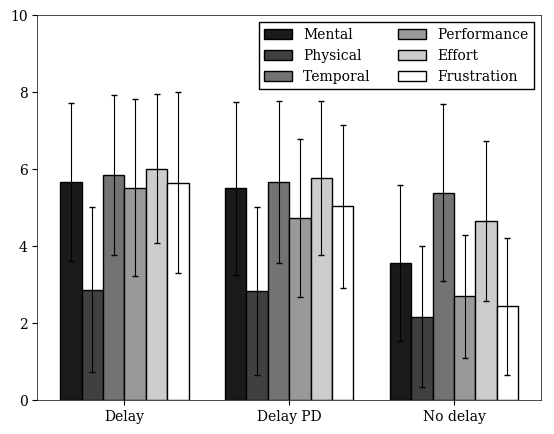

In [299]:
tlx_metrics = ['Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration']
filename = 'nasa_tlx_bar'
plt.style.use('default')
plt.style.use('thesis.mplstyle')

n_partic = pd.read_sql_query("select rowid from actors where valid=1 ;", conn).size
fig1, ax1 = plt.subplots(figsize=(6.5,5))
tlx_answers = []

bar_width= 0.13

for idx, metric in enumerate(tlx_metrics):
    data = np.zeros([n_partic,3])
    for exp in range(3):
        load = pd.read_sql_query("select {} from survey where valid=1 and experiment={};"
                                 .format(metric, exp), conn)
        data[...,exp] = np.reshape(np.array(load),(57,))
    if metric == 'Performance':
        data = np.ones_like(data)*10-data
    mean_ = data.mean(axis=0)
    std_ = data.std(axis=0)
    x_pos = np.arange(3)+1 - bar_width*3 +idx*bar_width+bar_width/2
    tlx_answers.append(data)
    print('{:.0f}%'.format((1-mean_[1]/mean_[0])*100))
    
    ax1.bar(x_pos, mean_, bar_width, yerr=std_, label=metric, 
            edgecolor='k', 
            linewidth=1,
           capsize=2,
           error_kw={'linewidth':0.8})


ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
ax1.set_xticks(np.arange(3)+1)
plt.ylim(0,10)
plt.legend(ncol=2)
plt.show()
# fig1.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

#### Significance

In [316]:
metric = 0
g0 = tlx_answers[metric][...,1]
g1 = tlx_answers[metric][...,2]
print_sig(g1, g0)
answers_means = np.copy(tlx_answers[metric]).mean(axis=0)
print(answers_means)
print('{:.0f}% decrease in subjective latency using predictor screen'.format((1-answers_means[1]/answers_means[0])*100))

t(56)=6.36, p$<$.001, d=0.902
[5.66666667 5.50877193 3.56140351]
3% decrease in subjective latency using predictor screen


### Subjective delay vs frustration

LinregressResult(slope=0.003628314819991917, intercept=2.39017490934138, rvalue=0.5949139473203121, pvalue=9.493453625753784e-18, stderr=0.0003770940959256629)
$R^2=0.35$, p=0.00000, err=0.00038


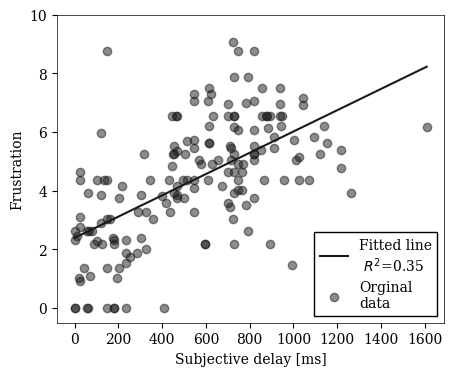

In [332]:
def avg_actor_delay(id):
    avg_delay = np.array(pd.read_sql_query("select delay from survey where valid=1 and actor={}".format(id), conn)).mean()
    return avg_delay

def avg_actor_frustration(id):
    avg_frus = np.array(pd.read_sql_query("select frustration from survey where valid=1 and actor={}".format(id), conn)).mean()
    return avg_frus

total_avg_frustration = np.array(pd.read_sql_query("select frustration from survey where valid=1", conn)).mean()
total_avg_delay = np.array(pd.read_sql_query("select delay from survey where valid=1", conn)).mean()

act = pd.read_sql_query("select rowid, * from actors where valid=1;", conn)
actor_ids = act.rowid.values
answ = [[],[]]

normalize = True
sel_exp = None
filename = 'delay_vs_frustration'

for actor_id in actor_ids:
    avg_delay = avg_actor_delay(actor_id)
    avg_frustration = avg_actor_frustration(actor_id)
    for exp in range(3):
        sur = pd.read_sql_query("select frustration, delay from survey where valid=1 and actor={} and experiment={}"
                                .format(actor_id, exp), conn)
        if normalize:
            frustration = float(sur['frustration'])/avg_frustration*total_avg_frustration
            delay = float(sur['delay'])/avg_delay*total_avg_delay
        else:
            frustration = float(sur['frustration'])
            delay = float(sur['delay'])
            
        if sel_exp is None or sel_exp is exp:
            answ[0].append(frustration)
            answ[1].append(delay)

x = answ[1]
y = answ[0]

linreg = linregress(x,y)
print(linreg)
x_min = min(x)
x_max = max(x)
print('$R^2={:.2f}$, p={:.5f}, err={:.5f}'.format(linreg.rvalue**2, linreg.pvalue, linreg.stderr))

plt.style.use('default')
plt.style.use('thesis.mplstyle')
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(x,y, marker='o', alpha=0.5, label='Orginal\ndata')
ax.plot(np.arange(x_min, x_max), np.arange(x_min, x_max)*linreg.slope+linreg.intercept, label='Fitted line\n $R^2$={:.2f}'
        .format(linreg.rvalue**2))
ax.legend()
plt.ylabel('Frustration')
plt.xlabel('Subjective delay [ms]')
plt.ylim([-0.5,10])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

## Delay times

In [23]:
data = pd.DataFrame()
for exp in range(3):
    data[exp] = pd.read_sql_query("select delay from survey where valid=1 and experiment={} order by actor asc;".format(exp), conn)
times = np.array(data)

### Absolute

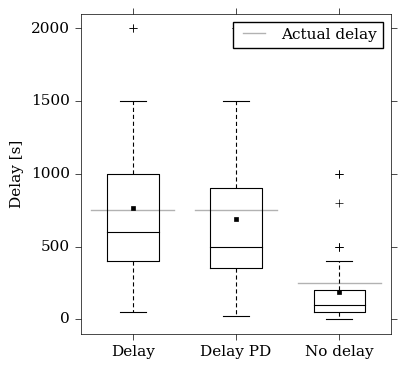

In [238]:
filename = 'subjective_delay_abs'
matplotlib.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(times, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
ax.plot([0.6,1.4], [750, 750], 'k', alpha=0.3, label='Actual delay')
ax.plot([1.6,2.4], [750, 750], 'k', alpha=0.3)
ax.plot([2.6,3.4], [250, 250], 'k', alpha=0.3)
ax.legend()
plt.ylabel('Delay [s]')
plt.ylim([-100,2100])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

### Normalized

In [223]:
sums = times.sum(axis=1)
averages = np.copy(times).mean(axis=0)
total_delay_average = np.copy(times).mean()
normalized = np.copy(times)
for idx, row in enumerate(normalized):
    user_avg = np.array([row[0], row[1], row[2]]).mean()
    row[0] = row[0]/user_avg*total_delay_average
    row[1] = row[1]/user_avg*total_delay_average
    row[2] = row[2]/user_avg*total_delay_average

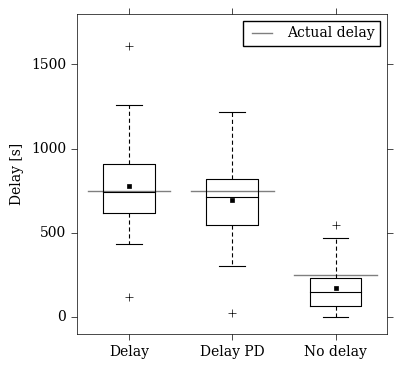

In [247]:
plt.style.use('classic')
plt.style.use('thesis.mplstyle')
filename = 'subjective_delay_norm'
fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(normalized, widths=0.5)
ax.plot([0.6,1.4], [750, 750], 'k', alpha=0.5, label='Actual delay')
ax.plot([1.6,2.4], [750, 750], 'k', alpha=0.5)
ax.plot([2.6,3.4], [250, 250], 'k', alpha=0.5)
ax.legend()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Delay [s]')
plt.ylim([-100,1800])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

In [244]:
norm_avg = np.copy(normalized).mean(axis=0)
print('{:.0f}% decrease in subjective latency using predictor screen'.format((1-norm_avg[1]/norm_avg[0])*100))
print_sig(normalized[...,1], normalized[...,0])

11% decrease in subjective latency using predictor screen
t(56)=1.40, p=0.167, d=0.356


## Key presses

In [28]:
data = pd.read_sql_query("select keydowns0, keydowns1, keydowns2 from actors where valid=1;", conn)
keys = np.array(data)

#### Absolute

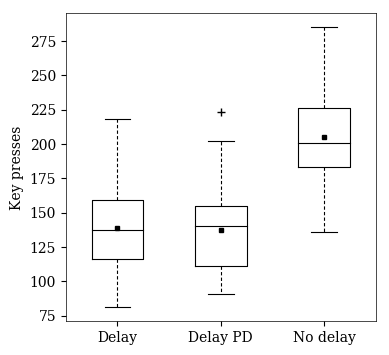

In [29]:
filename = 'keypresses'
matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(keys, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Key presses')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

## Learning effect

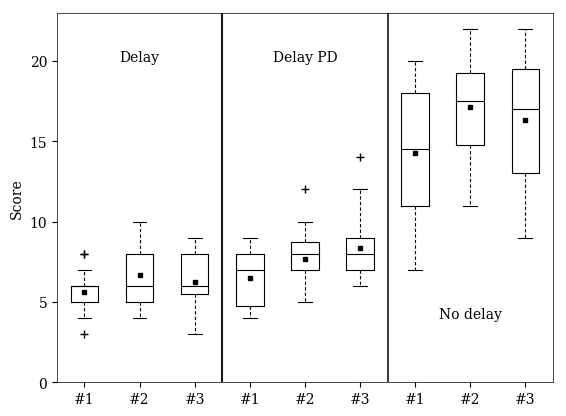

In [119]:
def condition_format(x, pos=None):
    names = ['#1', '#2', '#3']*3
    return names[x-1]

filename = 'learning_effect'

pos = [[0,1,2,4,3,5],
      [2,3,0,5,1,4],
      [4,5,1,3,0,2]]

all_li = []

for exp in range(3):
    first = pd.read_sql_query("select tothitsexp{} from actors where valid=1 and crowd={} or crowd={};"
                              .format(exp, pos[exp][0], pos[exp][1]), conn)
    middle = pd.read_sql_query("select tothitsexp{} from actors where valid=1 and crowd={} or crowd={};"
                              .format(exp, pos[exp][2], pos[exp][3]), conn)
    last = pd.read_sql_query("select tothitsexp{} from actors where valid=1 and crowd={} or crowd={};"
                              .format(exp, pos[exp][4], pos[exp][5]), conn)

    li = [first['tothitsexp'+str(exp)], middle['tothitsexp'+str(exp)],last['tothitsexp'+str(exp)]]
    all_li.extend(li)

fig, ax = plt.subplots()
ax.boxplot([list(i) for i in all_li])
ax.plot([3.5, 3.5],[0,23])
ax.plot([6.5, 6.5],[0,23])
plt.ylabel('Score')
plt.text(2, 20, 'Delay', fontsize=10, ha='center')
plt.text(5, 20, 'Delay PD', fontsize=10, ha='center')
plt.text(8, 4, 'No delay', fontsize=10, ha='center')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(condition_format))
plt.ylim([0,23])
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

In [142]:
num1 = 6
num2 = num1+1
ns = min(len(all_li[num1]), len(all_li[num2]))
print(ns)

print_sig(all_li[num1][:ns], all_li[num2][:ns])

18
t(17)=3.26, p=0.005, d=0.902


## Gamers

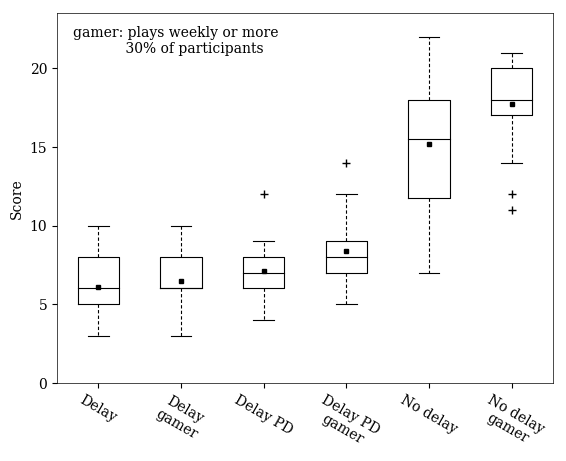

In [62]:
def game_format(x, pos=None):
    names = {1: 'Delay',
             2: 'Delay\ngamer',
            3: 'Delay PD',
            4: 'Delay PD\ngamer',
            5: 'No delay',
            6: 'No delay\ngamer'}
    return names[x]

gamers = pd.read_sql_query("select rowid, * from actors where valid=1 and game<=1;", conn)
ga = np.array(gamers[['tothitsexp0', 'tothitsexp1', 'tothitsexp2']])
non_gamers = pd.read_sql_query("select rowid, * from actors where valid=1 and game >1;", conn)
no = np.array(non_gamers[['tothitsexp0', 'tothitsexp1', 'tothitsexp2']])

game_per = len(gamers)/(len(gamers)+len(non_gamers))

filename = 'gamer_performance'
fig1, ax1 = plt.subplots()
# ax1.set_title('Performance gamers vs non gamers')
ax1.boxplot([no[...,0], ga[...,0], no[...,1], ga[...,1], no[...,2], ga[...,2]])
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(game_format))
plt.ylabel('Score')
plt.text(0.7, 21, 'gamer: plays weekly or more\n            {:.0f}% of participants'.format(game_per*100), fontsize=10)
plt.xticks(rotation=-30)
plt.ylim([0,23.5])
plt.show()
fig1.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

In [157]:
exp = 2
print_sig(no[...,0], no[...,1])
print_sig(ga[...,0], ga[...,1])

t(39)=3.27, p=0.002, d=0.577
t(16)=4.17, p<.001, d=1.018
